In [1]:
%pip install pandas matplotlib numpy torch torchvision
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torch.utils.data
import torchvision.models as models
import torchvision.transforms as transforms


# !pip install d2l==1.0.3

Note: you may need to restart the kernel to use updated packages.


In [2]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from torch.optim import Optimizer

class MyAdam(torch.optim.Adam):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999),lambdas=(0.84,0.84)):
        super().__init__(params, lr=lr, betas=betas)
        self.lambdas = lambdas

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError("Adam does not support sparse gradients")

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state["step"] = 0
                    # Exponential moving average of gradient values
                    state["exp_avg"] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state["exp_avg_sq"] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"]
                beta1, beta2 = group["betas"]
                lambda1,lambda2 = self.lambdas[0], self.lambdas[1]
                beta_t = [beta1 * torch.exp(-lambda1 * torch.linalg.norm(p.grad, ord=np.inf)),beta2 * torch.exp(-lambda2 * torch.linalg.norm(p.grad, ord=np.inf))]
                state["step"] += 1

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta_t[0]).add_(1 - beta_t[0], p.grad)
                exp_avg_sq.mul_(beta_t[1]).addcmul_(1 - beta_t[1], p.grad, p.grad)

                exp_avg_sq = torch.max(state["exp_avg_sq"] , exp_avg_sq)

                denom = exp_avg_sq.sqrt().add_(group["eps"])

                bias_correction1 = 1 - beta_t[0] ** state["step"]
                bias_correction2 = 1 - beta_t[1] ** state["step"]
                learning_rate = group["lr"] #/ (np.sqrt(state["step"]))
                step_size =  learning_rate * torch.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom)


# Logistic Regression on IMDB Movie Reviews

In [4]:
import pandas as pd
# Load data
df = pd.read_csv('./imdb_reviews_dataset.csv')
df['type_review'] = df['id'].apply(lambda x: x.split('_')[0])
df_labeled = df[df['type_review'] != 'unsup'].copy()
df_labeled['sentiment'] = df_labeled['type_review'].apply(lambda x: 1 if x == 'pos' else 0)
df_labeled['len_text'] = df_labeled['text'].apply(lambda x: len(x.split()))
display(df_labeled)

,data_type,id,rating,text,type_review,sentiment,len_text
0,train,pos_0,9,Bromwell High is a cartoon comedy. It ran at t...,pos,1,140
1,train,pos_10000,8,Homelessness (or Houselessness as George Carli...,pos,1,428
2,train,pos_10001,10,Brilliant over-acting by Lesley Ann Warren. Be...,pos,1,147
3,train,pos_10002,7,This is easily the most underrated film inn th...,pos,1,124
4,train,pos_10003,8,This is not the typical Mel Brooks film. It wa...,pos,1,120
...,...,...,...,...,...,...,...
99995,test,neg_9998,1,I occasionally let my kids watch this garbage ...,neg,0,108
99996,test,neg_9999,1,When all we have anymore is pretty much realit...,neg,0,163
99997,test,neg_999,3,The basic genre is a thriller intercut with an...,neg,0,268
99998,test,neg_99,3,Four things intrigued me as to this film - fir...,neg,0,126


In [5]:
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
# # shuffle the data, since the file stores all negative tweets first
original_data = [(text, sentiment) for text, sentiment in zip(df_labeled['text'], df_labeled['sentiment'])]

import random
random.seed(125)
random.shuffle(original_data)

data = original_data#[:5000]

total_size = len(data)
set_1_size = int(0.7 * total_size)
set_2_size = int(0.1 * total_size)
set_3_size = int(0.2 * total_size)

reviews = [text for (text, sentiment) in data]
vectorizer = CountVectorizer()
bow_model = vectorizer.fit_transform(reviews)
encoded_reviews = bow_model.toarray().astype(np.float32)
data = [(encoded_reviews[i], data[i][1]) for i in range(total_size)]

In [7]:
train_data_movies = data[:set_1_size]
val_data_movies  = data[set_1_size:set_1_size+set_2_size]
test_data_movies  = data[set_1_size+set_2_size:]

In [8]:
def accuracy(model, dataset):
    """
    Same signature as the `accuracy_basic()` function, but we will use a DataLoader and process
    100 images at a time
    """
    correct, total = 0, 0
    loader = torch.utils.data.DataLoader(dataset, batch_size=100)
    for X, t in loader:
        # X = X.to(device)
        # t = t.to(device)
        z = model(X) # TODO: use a single call to `model()` here as before
        pred =  torch.argmax(z,axis=1)# TODO: `pred` should have the same shape as `t`
        correct += int(torch.sum(t == pred))# TODO: update `correct` and `total`
        total += t.shape[0]
    return torch.tensor(correct / total)

In [9]:
def train_model(model,
                train_data,
                val_data,
                optimizer_choice = None,
                lambdas = (0.8,0.8),
                betas=(0.9, 0.999),
                learning_rate=0.001,
                batch_size=128,
                num_epochs=5,
                plot_every=5,
                ):
    """
    Train the PyTorch model `model` using the training data `train_data` and the
    corresponding hyperparameters. Report training loss, training accuracy, and
    validation accuracy every `plot_every` iterations.
    """
    # model = model.to(device)
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=True) # reshuffle minibatches every epoch


    criterion = nn.CrossEntropyLoss()


    if optimizer_choice == "Adam":
      optimizer = optim.Adam(model.parameters(), # the parameters to optimize
                      lr=0.005)
    elif optimizer_choice == "New_Adam":
      optimizer = MyAdam(model.parameters(), # the parameters to optimize
                      lr=0.005, lambdas = lambdas)
    elif optimizer_choice == "NAdam":
      optimizer = optim.NAdam(model.parameters(), # the parameters to optimize
                      lr=0.005)
    elif optimizer_choice == "RAdam":
      optimizer = optim.RAdam(model.parameters(), # the parameters to optimize
                      lr=0.005)
    # these lists will be used to track the training progress
    # and to plot the training curve
    iters, train_loss, train_acc, val_acc = [], [], [], []
    iter_count = 0 # count the number of iterations that has passed


    for e in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):

            # images = images.to(device)
            # labels = labels.to(device)
            z = model(images) # TODO

            loss = criterion(z, labels) # TODO

            loss.backward() # propagate the gradients
            optimizer.step() # update the parameters
            optimizer.zero_grad() # clean up accumualted gradients

            iter_count += 1
            if iter_count % plot_every == 0:
                iters.append(iter_count)
                train_loss.append(float(loss))
                t_acc = accuracy(model, train_data)
                train_acc.append(t_acc)
                v_acc = accuracy(model, val_data)
                val_acc.append(v_acc)

        print(f"Epoch [{e}] training loss: {loss}   training acc: {t_acc}   validation acc: {v_acc}")



    return iters, train_loss, train_acc, val_acc

In [10]:
model2 = nn.Sequential(
    nn.Linear(bow_model.shape[1], 2),
    nn.Softmax(dim=1)
)
iters2, train_loss2, train_acc2, val_acc2 = train_model(model2, train_data_movies, val_data_movies,optimizer_choice="New_Adam",lambdas=(0.8,0.8))

model1 = nn.Sequential(
    nn.Linear(bow_model.shape[1], 2),
    nn.Softmax(dim=1)
)
iters1, train_loss1, train_acc1, val_acc1 = train_model(model1, train_data_movies, val_data_movies,optimizer_choice="Adam")

/var/folders/2d/q4r8sw2j1m71lm5p7cm2ggyr0000gn/T/ipykernel_41250/315776784.py:34: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/python_arg_parser.cpp:1630.)
  exp_avg.mul_(beta_t[0]).add_(1 - beta_t[0], p.grad)


Epoch [0] training loss: 0.41881683468818665   training acc: 0.9178571701049805   validation acc: 0.897599995136261
Epoch [1] training loss: 0.3826802372932434   training acc: 0.9319714307785034   validation acc: 0.8998000025749207
Epoch [2] training loss: 0.3486611843109131   training acc: 0.9377999901771545   validation acc: 0.8984000086784363
Epoch [3] training loss: 0.35811907052993774   training acc: 0.9451714158058167   validation acc: 0.8996000289916992
Epoch [4] training loss: 0.37612104415893555   training acc: 0.9520000219345093   validation acc: 0.9021999835968018
Epoch [0] training loss: 0.3950197100639343   training acc: 0.9482285976409912   validation acc: 0.8985999822616577
Epoch [1] training loss: 0.38085299730300903   training acc: 0.9718285799026489   validation acc: 0.9025999903678894
Epoch [2] training loss: 0.3540189266204834   training acc: 0.9811142683029175   validation acc: 0.9016000032424927
Epoch [3] training loss: 0.32810187339782715   training acc: 0.985514

In [11]:
model3 = nn.Sequential(
    nn.Linear(bow_model.shape[1], 2),
    nn.Softmax(dim=1)
)
iters3, train_loss3, train_acc3, val_acc3 = train_model(model3, train_data_movies, val_data_movies,optimizer_choice="NAdam")

model4 = nn.Sequential(
    nn.Linear(bow_model.shape[1], 2),
    nn.Softmax(dim=1)
)
iters4, train_loss4, train_acc4, val_acc4 = train_model(model4, train_data_movies, val_data_movies,optimizer_choice="RAdam")

Epoch [0] training loss: 0.41483062505722046   training acc: 0.949657142162323   validation acc: 0.8998000025749207
Epoch [1] training loss: 0.3722964823246002   training acc: 0.9718571305274963   validation acc: 0.9064000248908997
Epoch [2] training loss: 0.40109890699386597   training acc: 0.9813143014907837   validation acc: 0.8999999761581421
Epoch [3] training loss: 0.32533010840415955   training acc: 0.9859142899513245   validation acc: 0.9049999713897705
Epoch [4] training loss: 0.32425564527511597   training acc: 0.9883999824523926   validation acc: 0.9034000039100647
Epoch [0] training loss: 0.4366930425167084   training acc: 0.9180571436882019   validation acc: 0.8831999897956848
Epoch [1] training loss: 0.3936849534511566   training acc: 0.9509714245796204   validation acc: 0.896399974822998
Epoch [2] training loss: 0.363951712846756   training acc: 0.9674285650253296   validation acc: 0.9010000228881836
Epoch [3] training loss: 0.3740536570549011   training acc: 0.976428568

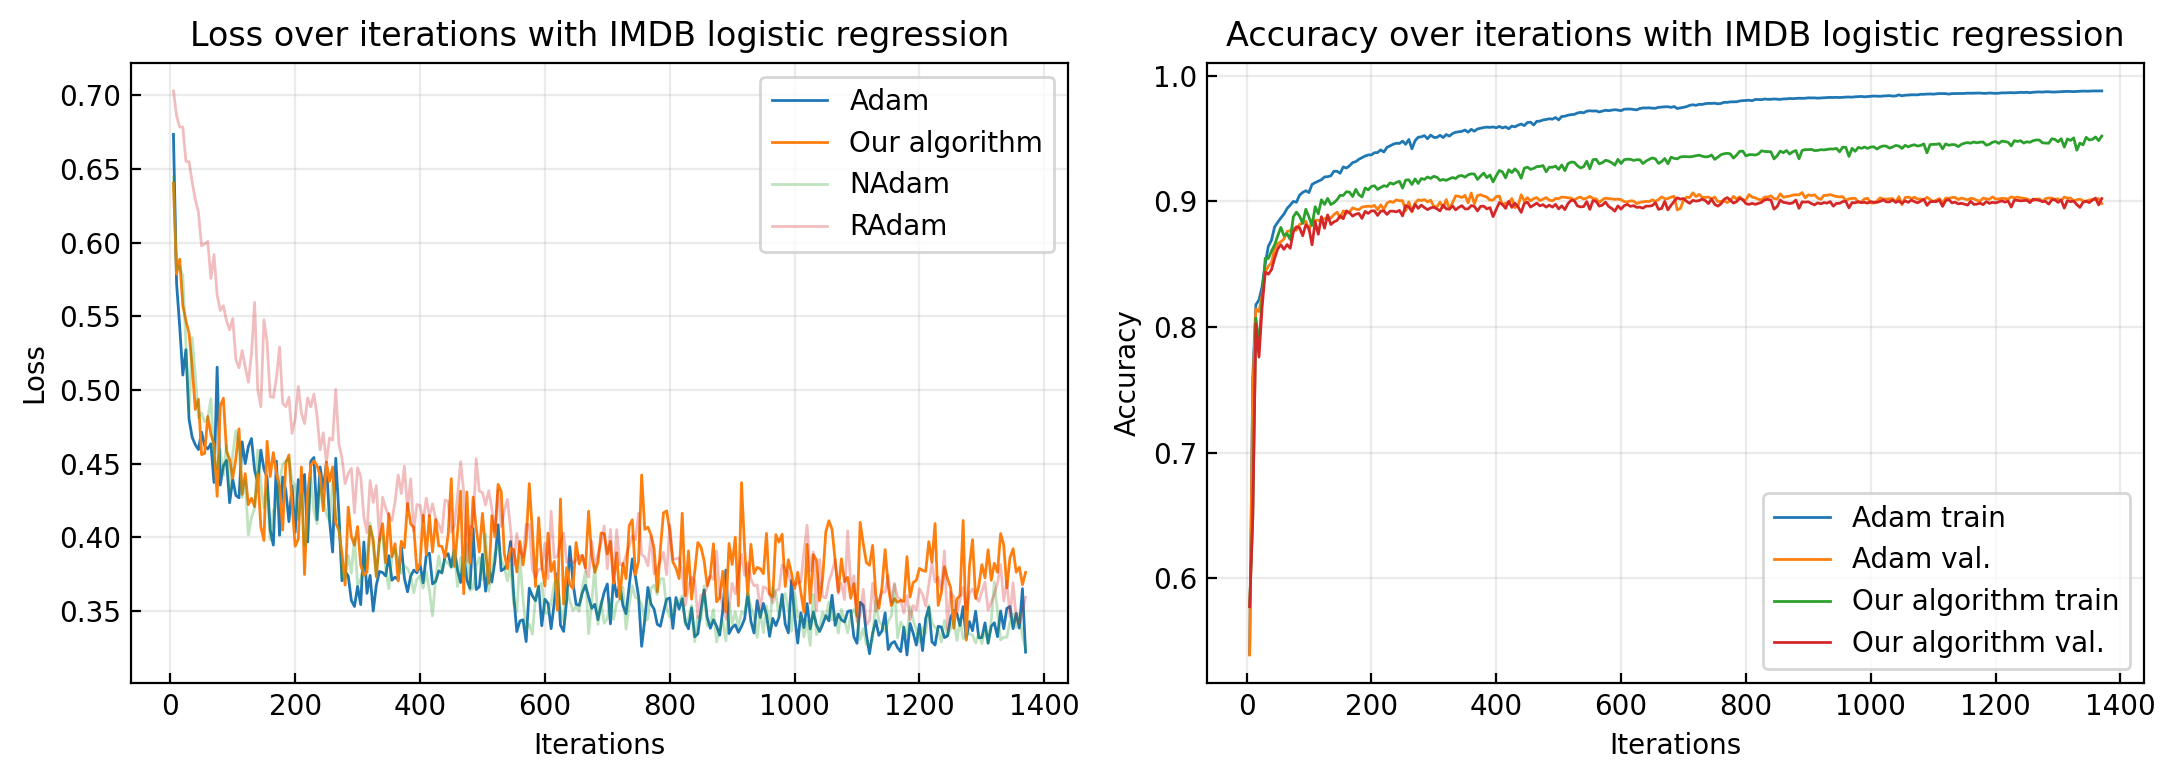

In [13]:
plt.figure(figsize=(11, 4), dpi=200)

plt.subplot(1, 2, 1)  # (rows, columns, plot_number)
plt.plot(iters1[:len(train_loss1)], train_loss1, label="Adam", lw=1)
plt.plot(iters2[:len(train_loss2)], train_loss2, label="Our algorithm", lw=1)
plt.plot(iters3[:len(train_loss3)], train_loss3, label="NAdam", lw=1, alpha=0.3)
plt.plot(iters4[:len(train_loss4)], train_loss4, label="RAdam", lw=1, alpha=0.3)
plt.title("Loss over iterations with IMDB logistic regression")
plt.tick_params(axis='both', direction='in')
plt.grid(True, alpha=0.25)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)  # (rows, columns, plot_number)
plt.plot(iters1[:len(train_acc1)], train_acc1, label="Adam train", lw=1)
plt.plot(iters1[:len(val_acc1)], val_acc1, label="Adam val.", lw=1)
plt.plot(iters2[:len(train_acc2)], train_acc2, label="Our algorithm train", lw=1)
plt.plot(iters2[:len(val_acc2)], val_acc2, label="Our algorithm val.", lw=1)
plt.tick_params(axis='both', direction='in')
plt.grid(True, alpha=0.25)
plt.title("Accuracy over iterations with IMDB logistic regression")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()


# Show the plots
plt.tight_layout()  # Adjusts subplot parameters to give specified padding
plt.show()